In [1]:
%load_ext autoreload
%autoreload 2
from dataprep import initialize_adata, balanceTrainingData, balanceTrainingData_pattern_noPattern
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random
import scanpy as sc
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
import torch
from tqdm import tqdm


/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 101
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
rng = np.random.RandomState(seed)


custom = {"axes.edgecolor": "grey"}
sns.set_style("whitegrid")
plt.rcParams['grid.alpha'] = 0.4
sns.set_palette("colorblind")
colorblind_palette = sns.color_palette("colorblind")

## Loading data
Initialize adata object?

In [3]:
#adata_all_spots = sc.read_h5ad("/media/gambino/students_workdir/nynke/data/all_spots_simulated_embeddings_adata.h5ad")
adata = sc.read_h5ad("/media/gambino/students_workdir/nynke/new_model_with_cell_id_left_out_custom_nynke_panel_simulated_embeddings_adata.h5ad")
#adata_mixed_cellID = sc.read_h5ad("/media/gambino/students_workdir/nynke/data/custom_nynke_panel_simulated_embeddings_adata.h5ad")

## Preprocessing data

In [4]:
adata = initialize_adata(adata)

In [5]:
adata_strong = adata[adata.obs['pattern_strength'] == 'strong']

adata_train = adata_strong[adata_strong.obs['cell_id'].isin(adata_strong.uns['train_cellIDs'])]
adata_test = adata_strong[adata_strong.obs['cell_id'].isin(adata_strong.uns['test_cellIDs'])]

In [6]:
adata_train_balanced = balanceTrainingData_pattern_noPattern(adata_train)
adata_test_balanced = balanceTrainingData_pattern_noPattern(adata_test)

## Gridsearch RF hyperparameters

Max features for the random forest at first will be put to sqrt(15) ~3. Based on validation will see whether want to change that to 4. 
* `n_estimators`: number of trees. According to scikit-learn, the larger the better, but does take longer to compute and at some point it doesn't really explain much extra variance. 
* `max_features`: size of random subset of features to consider when splitting a node. The lower: the greater reduction in variance, but the higher increase in bias. Empirical good default values: max_features=”sqrt” (according to [scikit-learn](https://scikit-learn.org/stable/modules/ensemble.html#random-forest-parameters))
    * Do parameter search [2,3,4,5], because sqrt(15)~3.87, so we choose 2,3,4,5 as values around that. 
* By default, bootstramp samples are used. When using bootstrap sampling, the generalization error can be estimated on the left out (or out-of-bag) samples. You can enable this with setting `oob_score=True`

In [7]:
adata_train_labels = adata_train_balanced.copy()
pattern_mapping = {'pattern': 1, 'random': 0}
adata_train_labels.obs.replace({'random_or_pattern':pattern_mapping}, inplace=True)

<ipython-input-7-de722ef2ea9b>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  adata_train_labels.obs.replace({'random_or_pattern':pattern_mapping}, inplace=True)


In [8]:
latent = adata_train_labels.obsm["latent"]
labels = adata_train_labels.obs["random_or_pattern"]

base_forest = RandomForestClassifier(random_state=seed, bootstrap=True, oob_score=True, n_estimators=100)
param_grid = {'max_features': [2,3,4,5]}

grid_search = GridSearchCV(base_forest, param_grid=param_grid, scoring='roc_auc', verbose=3, error_score='raise', n_jobs = 5)
grid_search.fit(latent,labels)

print(grid_search.cv_results_)
print("Best parameters: ")
print(grid_search.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


{'mean_fit_time': array([16.63249526, 24.57400088, 32.62529941, 40.67510395]), 'std_fit_time': array([0.64641187, 1.09631156, 1.69822104, 1.80359592]), 'mean_score_time': array([0.21051154, 0.20286527, 0.1990869 , 0.19553113]), 'std_score_time': array([0.01778204, 0.01718382, 0.01607339, 0.01570146]), 'param_max_features': masked_array(data=[2, 3, 4, 5],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'max_features': 2}, {'max_features': 3}, {'max_features': 4}, {'max_features': 5}], 'split0_test_score': array([0.91063477, 0.91094238, 0.91035068, 0.90996012]), 'split1_test_score': array([0.98084836, 0.98101615, 0.98030512, 0.980007  ]), 'split2_test_score': array([0.98391185, 0.9842472 , 0.98443334, 0.98437324]), 'split3_test_score': array([0.98720169, 0.98783447, 0.98791014, 0.98887897]), 'split4_test_score': array([0.98554207, 0.98510281, 0.98571303, 0.98526644]), 'mean_test_score': array([0.96962775, 0.9698286 , 0.9697424

In [10]:
train_accuracy = []
test_accuracy = []
for count in tqdm(range(50, 401, 50)):
    # create random forest classifier and fit on training data
    rf_classifier = RandomForestClassifier(n_estimators=count, random_state=seed, max_features=3, bootstrap=True, oob_score=True, n_jobs = 5)
    rf_classifier.fit(adata_train_balanced.obsm["latent"], adata_train_balanced.obs["random_or_pattern"]) #first test on pattern/no pattern. Then will select the pattern and cluster that again. 
    
    #predict label
    train_pred = rf_classifier.predict_proba(adata_train_balanced.obsm["latent"])[:,1]
    test_pred = rf_classifier.predict_proba(adata_test_balanced.obsm["latent"])[:,1]

    # Obtain training and validation AUC score. 
    train_auc = roc_auc_score(adata_train_balanced.obs["random_or_pattern"], train_pred)
    test_auc = roc_auc_score(adata_test_balanced.obs["random_or_pattern"], test_pred)

    #append scores to lists
    train_accuracy.append(train_auc)
    test_accuracy.append(test_auc)

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [02:12<00:00, 16.54s/it]


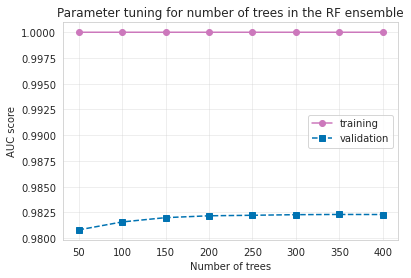

In [11]:
plt.figure()

x_values = range(50, 401, 50)

plt.plot(x_values, train_accuracy, label='training', linestyle='-', marker='o', color=colorblind_palette[4])
plt.plot(x_values, test_accuracy, label='validation', linestyle='--', marker='s', color=colorblind_palette[0])

# Add labels and legend
plt.title('Parameter tuning for number of trees in the RF ensemble')
plt.xlabel('Number of trees')
plt.ylabel('AUC score')
plt.legend()
plt.show()

Looks like it plateaus at 200 trees, so we'll use that. 

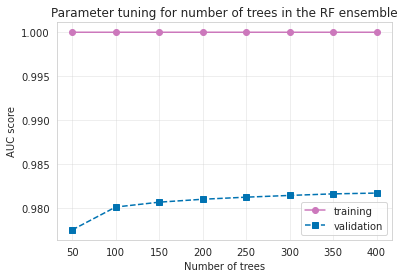

In [27]:
plt.figure()

x_values = range(50, 401, 50)

plt.plot(x_values, train_accuracy, label='training', linestyle='-', marker='o', color=colorblind_palette[4])
plt.plot(x_values, test_accuracy, label='validation', linestyle='--', marker='s', color=colorblind_palette[0])

# Add labels and legend
plt.title('Parameter tuning for number of trees in the RF ensemble')
plt.xlabel('Number of trees')
plt.ylabel('AUC score')
plt.legend()
plt.show()

In [29]:
train_accuracy

[0.9999998732535212,
 0.9999999977134706,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9999999999999999]

In [28]:
test_accuracy

[0.9775129077222445,
 0.9801133199226464,
 0.9806688365730073,
 0.9810005072684901,
 0.9812376223171955,
 0.9814353424168972,
 0.9816142243041353,
 0.9817031173594569]

## Final function, training and saving of RF model

In [12]:
def train_RF(adata_train, adata_test, classes: str = "random_or_pattern", n_trees:int = 200, max_features:int = 3, n_jobs: int = 4, confusion_bool: bool = False) -> RandomForestClassifier:
    ''' Function to train a Random Forest classifier on the latent space of the adata_train object

    Parameters:
    ----------
    adata_train: AnnData object containing the training data
    adata_test: AnnData object containing the test data
    classes: class to predict. Default is pattern versus non-pattern, alternatively a column with e.g. 'pericellular' versus 'other_patterns' could be used.
    n_trees:
    max_features: Number of features to consider when looking for the best split. Default is 3.
    n_jobs: Included to speed up the training process. Default is 4, but should be adjusted to 1 for RF object used within multiprocessing, such as the power analysis.
    confusion_bool: Whether to plot a confusion matrix. Default is False.
    '''
    rf = RandomForestClassifier(n_estimators=n_trees, random_state=seed, max_features=max_features, bootstrap=True, oob_score=False, n_jobs = n_jobs)
    rf.fit(adata_train.obsm["latent"], adata_train.obs[classes]) 
    
    pred_probabilities = rf.predict_proba(adata_test.obsm["latent"])

    print(f"auc: {classes}", roc_auc_score(adata_test.obs[classes], pred_probabilities[:,1]))

    if confusion_bool:
        pred_binary = rf.predict(adata_test.obsm["latent"])
        confusion_object = confusion_matrix(adata_test.obs[classes], pred_binary, labels = [classes,"other"])
        cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_object, display_labels = [classes.capitalize(), "Other"]) 
        cm_display.plot()
        plt.title("Confusion Matrix")
        plt.show()

    return rf

In [13]:
rf = train_RF(adata_train_balanced, adata_test_balanced, classes = "pericellular", n_jobs = 4)

auc: pericellular 0.9969551205053102


In [ ]:
path = "temp_objects/rf_pattern_nonpattern.pkl"

# Open the file in write-binary mode and dump the object
with open(path, 'wb') as f:
    pickle.dump(rf, f)

## Balanced / Unbalanced figure

In [ ]:
adata_test_allstrengths = adata_split_cellID[adata_split_cellID.obs['cell_id'].isin(adata_split_cellID.uns['test_cellIDs'])]
pattern_strength = ["low", "intermediate", "strong"]
# 'unbalanced': rf_peri_unbalanced, 'balanced': rf_peri_balanced, 'unbalanced_inclRandom': rf_peri_balanced_inclRandom
models= {"Balanced: ": rf_peri_balanced,"Unbalanced: ": rf_peri_unbalanced}
predictions = {}

fig, ax = plt.subplots()

for strength in pattern_strength:
    for name, model in models.items():
        adata_test_strength = adata_test_allstrengths[adata_test_allstrengths.obs["pattern_strength"]==strength]
        test_pred = model.predict_proba(adata_test_strength.obsm["latent"])[:,1]
        predictions[name] = RocCurveDisplay.from_predictions(
            adata_test_strength.obs['pericellular'],
            test_pred, 
            pos_label = "pericellular",
            name = f"{name}{strength} pattern strength",
            ax=ax)
_ = ax.set(xlabel = "False Positive Rate",
    ylabel = "True Positive Rate",
    title = "ROC Curve, Pericellular versus other Patterns"
    )

plt.legend(bbox_to_anchor=(0, -0.4, 1,0.2), loc="upper center")
plt.show()
#adata_test_balanced.obs['n_spots_interval'].value_counts()

## ROC curves of the optimal model

# K - nearest neighbours

Choice of k depends on the input data --> more outliers or noise performs better with a larger k (due to smoothing)

Recommended to have an odd number of k to avoid ties in classification. Use cross-validation to choose optimal k for the dataset.

Rule of thumb: choose a k close to the sqrt(datapoints), aka sqrt(100688)~317 (datapoints ~ 100.000 because we balanced the dataset)

Hyperparameter grid choice. Rule of thumb is that the sqrt(N) will work, and to use odd numbers. Therefore use sqrt as a center and 5 values above and below it. Given that 317 is a relatively large number, will first explore a larger space (i.e. 50 interval in between).


In [15]:
# Scaling the latent space for KNN, using the MinMaxScaler
scaler = MinMaxScaler()
adata_train_labels.obsm['latent']=scaler.fit_transform(adata_train_labels.obsm['latent'])

In [16]:
adata_train_labels

AnnData object with n_obs × n_vars = 100688 × 15
    obs: 'pattern', 'random_or_pattern', 'n_spots', 'n_spots_interval', 'cell_id', 'genes', 'rotation', 'rotation_interval', 'blur', 'prop', 'prop_interval', 'corresponding_dapis', 'train_or_val', 'original_image_paths', 'pattern_strength', 'rna_count', 'cell-edge', 'extranuclear', 'foci', 'intranuclear', 'nuclear-edge', 'pericellular', 'perinuclear', 'protrusion', 'random'
    obsm: 'latent'

In [17]:
np.sqrt(100688)

317.31372488438

[69,119,169,219,269,319,369,419,469,519,569,619,669]
intervals for unbalanced training set. 

Fitting 5 folds for each of 13 candidates, totalling 65 fits


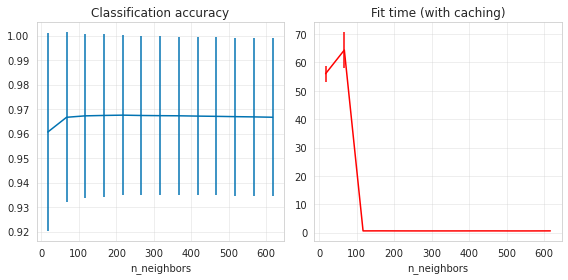

In [21]:
# Author: Tom Dupre la Tour
#
# License: BSD 3 clause
from tempfile import TemporaryDirectory

import matplotlib.pyplot as plt

#from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsTransformer
from sklearn.pipeline import Pipeline

latent = adata_train_labels.obsm["latent"]
labels = adata_train_labels.obs["random_or_pattern"]
n_neighbors_list = [17,67,117,167,217,267,317,367,417,467,517,567,617]

# The transformer computes the nearest neighbors graph using the maximum number
# of neighbors necessary in the grid search. The classifier model filters the
# nearest neighbors graph as required by its own n_neighbors parameter.
graph_model = KNeighborsTransformer(n_neighbors=max(n_neighbors_list), mode="distance")
classifier_model = KNeighborsClassifier(metric="precomputed")

# Note that we give `memory` a directory to cache the graph computation
# that will be used several times when tuning the hyperparameters of the
# classifier.
with TemporaryDirectory(prefix="sklearn_graph_cache_") as tmpdir:
    full_model = Pipeline(
        steps=[("graph", graph_model), ("classifier", classifier_model)], memory=tmpdir
    )

    param_grid = {"classifier__n_neighbors": n_neighbors_list}
    grid_model = GridSearchCV(full_model, param_grid, verbose = 3, scoring='roc_auc', error_score='raise', n_jobs=10)
    grid_model.fit(latent, labels)

# Plot the results of the grid search.
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].errorbar(
    x=n_neighbors_list,
    y=grid_model.cv_results_["mean_test_score"],
    yerr=grid_model.cv_results_["std_test_score"],
)
axes[0].set(xlabel="n_neighbors", title="Classification accuracy")
axes[1].errorbar(
    x=n_neighbors_list,
    y=grid_model.cv_results_["mean_fit_time"],
    yerr=grid_model.cv_results_["std_fit_time"],
    color="r",
)
axes[1].set(xlabel="n_neighbors", title="Fit time (with caching)")
fig.tight_layout()
plt.show()

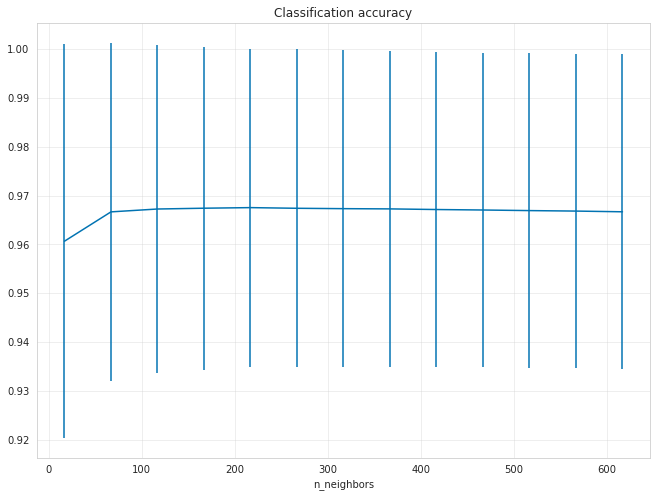

In [23]:
# Plot the results of the grid search.
fig, axes = plt.subplots(1, 1, figsize=(11, 8))
axes.errorbar(
    x=n_neighbors_list,
    y=grid_model.cv_results_["mean_test_score"],
    yerr=grid_model.cv_results_["std_test_score"],
)
axes.set(xlabel="n_neighbors", title="Classification accuracy")
plt.show()

5th one seems best

In [24]:
print(grid_model.cv_results_["mean_test_score"])
grid_model.cv_results_["std_test_score"]

[0.96065581 0.96666586 0.96725199 0.96741662 0.96753821 0.96740127
 0.9673247  0.96727598 0.96714676 0.96704931 0.96692788 0.96682815
 0.96668201]


array([0.04035533, 0.03465162, 0.03358705, 0.03307767, 0.03257122,
       0.03256637, 0.03245957, 0.03232408, 0.03234059, 0.03225918,
       0.0322456 , 0.03219674, 0.03226172])

## Training RF for specific pattern

In [50]:
def traintest_split_specific_pattern(adata, test_pattern: int = 'pericellular', balanced: bool = True, include_random: bool = False):
    adata_train = adata[adata.obs['cell_id'].isin(adata.uns['train_cellIDs'])]
    adata_test = adata[adata.obs['cell_id'].isin(adata.uns['test_cellIDs'])]

    if balanced:
        if include_random:
            adata_train = balanceTrainingData(adata_train, testPattern = test_pattern, include_random = True, random_seed = seed)
            adata_test = balanceTrainingData(adata_test, testPattern = test_pattern, include_random = True, random_seed = seed)
        else:
            adata_train = balanceTrainingData(adata_train, testPattern = test_pattern, include_random = False, random_seed = seed)
            adata_test = balanceTrainingData(adata_test, testPattern = test_pattern, include_random = False, random_seed = seed)
    return adata_train, adata_test